In [1]:
%run init.ipynb

In [2]:
from qiskit import *

# Hamiltoniano Heisenberg XXX
$$H_{3x} = J\sum_{\langle j,k\rangle}\big(\sigma_{j}^{x}\sigma_{k}^{x}+\sigma_{j}^{y}\sigma_{k}^{y}+\sigma_{j}^{z}\sigma_{k}^{z}\big).$$

## Dinâmica exata para 3 spins
Para uma linha com __3 spins__ teremos
\begin{align}
H_{3x} = X\otimes X\otimes I + I\otimes X\otimes X + Y\otimes Y\otimes I + I\otimes Y\otimes Y + Z\otimes Z\otimes I + I\otimes Z\otimes Z
\end{align}

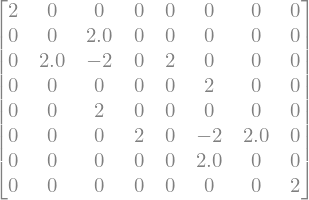

In [26]:
def Hxxx():
    H = tp(tp(pauli(1),pauli(1)),id(2)) + tp(id(2),tp(pauli(1),pauli(1)))\
    + tp(tp(pauli(2),pauli(2)),id(2)) + tp(id(2),tp(pauli(2),pauli(2)))\
    + tp(tp(pauli(3),pauli(3)),id(2)) + tp(id(2),tp(pauli(3),pauli(3)))
    return H
H = Hxxx(); H

In [27]:
#eig

In [28]:
#eig = H.eigenvects(); eig[0], eig[0][0], eig[0][2][0]

$$U = e^{iHt}$$

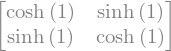

In [29]:
def mat_exp(A):
    d = A.shape[0]; eig = A.eigenvects(); Aexp = zeros(d,d); ne = 0; j = 0; lk = 0
    while ne < d:
        mult = eig[j][1]; ne += mult
        for k in range(0,mult):
            Proj = proj(eig[j][2][k]); Aexp += exp(eig[j][0])*(Proj/trace(Proj))
        j += 1
    return Aexp
simplify(mat_exp(pauli(1)))

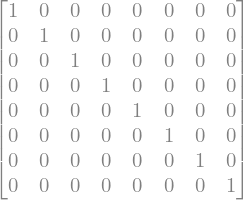

In [30]:
def UHxxx(t):
    H = Hxxx()
    return mat_exp(-1j*t*H)
U = UHxxx(0); U

$$|\psi_{0}\rangle = |110\rangle$$

In [31]:
psi0 = tp(tp(cb(2,1),cb(2,1)),cb(2,0)); #psi0
dt = 0.05; t = np.arange(0, 2*pi+dt, dt); d = len(t); F = np.zeros(d);  psit = psi0
for j in range(0, d):
    U = UHxxx(t[j]); psit = U*psi0
    ip = inner_product(psi0,psit); F[j] = ip*conjugate(ip)
    #print(t[j], F[j])    

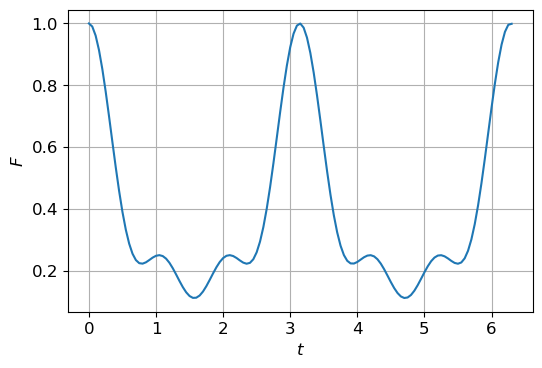

In [32]:
plt.figure(figsize = (6,4), dpi = 100)
plt.plot(t, F); plt.xlabel(r'$t$'); plt.ylabel(r'$F$'); plt.grid(); plt.show()

Note que a dinâmica, neste caso, é periódica com período igual a $\pi$.

# Trotterização
Considere um Hamiltoniano 
$$H = H_{a} + H_{b}.$$
Se $[H_{a},H_{b}]=\mathbb{O}$, temos que
$$U = e^{-iHt} = e^{-iH_{a}t-iH_{b}t} = e^{-iH_{a}t}e^{-iH_{b}t} = U_{b}U_{a} = U_{a}U_{b}.$$
Se $[H_{a},H_{b}]\ne\mathbb{O}$, podemos utilizar a decomposição de Trotter-Suzuki, que lê-se:
$$e^{-iHt} \equiv \lim_{n\rightarrow\infty}\Big(e^{-iH_{a}t/n}e^{-iH_{b}t/n}\Big)^{n}.$$
Ou seja, se dividimos o intervalo de tempo em um conjunto infinito de intervalos infinitesimais, podemos tratar os componentes do Hamiltoniano como se comutassem.

## Escolha da decomposição
Em relação ao Hamiltoniano de 3 spins 1/2 visto acima, podemos definir Hamiltonianos de 2 spins como segue
\begin{align}
H_{3x}^{12} & = X\otimes X\otimes I + Y\otimes Y\otimes I + Z\otimes Z\otimes I, \\
& = \big(X\otimes X + Y\otimes Y + Z\otimes Z\big)\otimes I, \\
H_{3x}^{23} &= I\otimes X\otimes X + I\otimes Y\otimes Y + I\otimes Z\otimes Z \\
 & = I\otimes \big(X\otimes X +  Y\otimes Y +  Z\otimes Z\big).
\end{align}
Com isso, vem que
$$H_{3x} = H_{3x}^{12} + H_{3x}^{23}.$$

OBS: Pode-se utilizar diferentes decomposições para testar qual é a melhor. 

OBS: Seria interessante verificar se exite alguma ligação da norma do operador utilizado na decomposição com a fidelidade obtida.

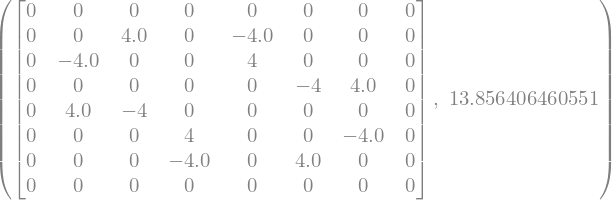

In [33]:
H12 = tp(tp(pauli(1),pauli(1)),id(2)) + tp(tp(pauli(2),pauli(2)),id(2)) + tp(tp(pauli(3),pauli(3)),id(2))
H23 = tp(id(2),tp(pauli(1),pauli(1))) + tp(id(2),tp(pauli(2),pauli(2))) + tp(id(2),tp(pauli(3),pauli(3)))
dH = comm(H12,H23); dH, dH.norm()

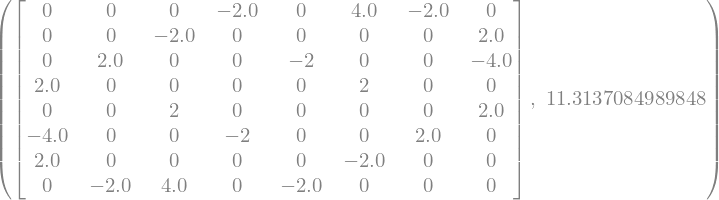

In [34]:
H1 = tp(tp(pauli(1),pauli(1)),id(2)) + tp(id(2),tp(pauli(1),pauli(1))) + tp(id(2),tp(pauli(3),pauli(3)))
H2 = tp(tp(pauli(2),pauli(2)),id(2)) + tp(id(2),tp(pauli(2),pauli(2))) + tp(tp(pauli(3),pauli(3)),id(2))
dH = comm(H1,H2); dH, dH.norm()

No entanto, existe uma motivação para usarmos a primeira decomposição. Usando
$$\sigma_{j}\sigma_{k} = \sigma_{0}\delta_{jk}+i\epsilon_{jkl}\sigma_{l},$$
para $j\ne k$, vemos que
\begin{align}
[\sigma_{j}\otimes\sigma_{j},\sigma_{k}\otimes\sigma_{k}] & = \sigma_{j}\sigma_{k}\otimes\sigma_{j}\sigma_{k} - \sigma_{k}\sigma_{j}\otimes\sigma_{k}\sigma_{j} \\
& = i\epsilon_{jkl}\sigma_{l}\otimes i\epsilon_{jkl}\sigma_{l} -i\epsilon_{kjl}\sigma_{l}\otimes i\epsilon_{kjl}\sigma_{l} \\
& = i^{2}\epsilon_{jkl}^{2}\sigma_{l}\otimes\sigma_{l} -i^{2}\epsilon_{kjl}^{2}\sigma_{l}\otimes \sigma_{l} \\
& = i^{2}\epsilon_{jkl}^{2}\sigma_{l}\otimes\sigma_{l} -i^{2}(-\epsilon_{jkl})^{2}\sigma_{l}\otimes \sigma_{l} \\
& = \mathbb{O}.
\end{align}
Ou seja,
$$[X\otimes X,Y\otimes Y] = [X\otimes X,Z\otimes Z] = [Y\otimes Y,Z\otimes Z] =\mathbb{O}.$$

OBS: Isso não é estranho do ponto de vista de medida simultânea de $\sigma_{j}\otimes\sigma_{j}$ e $\sigma_{k}\otimes\sigma_{k}$? Pense em como essas medidas são feitas no IBMQ ... Note também que $\sigma_{j}$ e $\sigma_{k}$ não são compatíveis para $j\ne k$.

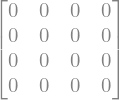

In [35]:
comm(tp(pauli(1),pauli(1)),tp(pauli(2),pauli(2)))

Com isso, vem que
\begin{align}
e^{-iH_{3x}^{12}t} & = e^{-it(X\otimes X\otimes I + Y\otimes Y\otimes I + Z\otimes Z\otimes I)} \\
& = e^{-itX\otimes X\otimes I}e^{-itY\otimes Y\otimes I}e^{-itZ\otimes Z\otimes I} \\
& = \Big(e^{-itX\otimes X}\otimes I\Big)\Big(e^{-itY\otimes Y}\otimes I\Big)\Big(e^{-itZ\otimes Z}\otimes I\Big), \\
& = \Big(e^{-itX\otimes X}\Big)\Big(e^{-itY\otimes Y}\Big)\Big(e^{-itZ\otimes Z}\Big)\otimes I, \\
e^{-iH_{3x}^{23}t} &= I\otimes\Big( e^{-itX\otimes X}\Big)\Big( e^{-itY\otimes Y}\Big)\Big( e^{-itZ\otimes Z}\Big),
\end{align}
em que usamos e.g. que 
$$e^{A\otimes I} = e^{A}\otimes I.$$

Com isso teremos
\begin{align}
U & = e^{-iH_{3x}t} = e^{-i(H_{3x}^{12}+H_{3x}^{23})t} = \lim_{j\rightarrow\infty}\Big(e^{-iH_{3x}^{12}t/j}e^{-iH_{3x}^{23}t/j}\Big)^{j} \\
& = \lim_{j\rightarrow\infty}\left(\Big(e^{-iX\otimes Xt/j}e^{-iY\otimes Yt/j}e^{-iZ\otimes Zt/j}\otimes I\Big)\Big(I\otimes e^{-iX\otimes Xt/j}e^{-iY\otimes Yt/j}e^{-iZ\otimes Zt/j}\Big)\right)^{j}.
\end{align}

## Efeito do número de passos de Trotter (cálculo "exato")
No desafio da IBM, deve-se usar um mínimo de $n=4$ passos na Trotterização. Teremos assim as aproximações
\begin{align}
U_{1} & = e^{-iH_{3x}^{12}t}e^{-iH_{3x}^{23}t} = B_{1}^{1}, \\
U_{2} & = e^{-iH_{3x}^{12}t/2}e^{-iH_{3x}^{23}t/2}e^{-iH_{3x}^{12}t/2}e^{-iH_{3x}^{23}t/2} = B_{2}^{2}, \\
U_{3} & = e^{-iH_{3x}^{12}t/3}e^{-iH_{3x}^{23}t/3}e^{-iH_{3x}^{12}t/3}e^{-iH_{3x}^{23}t/3}e^{-iH_{3x}^{12}t/3}e^{-iH_{3x}^{23}t/3} = B_{3}^{3}, \\
U_{4} & = e^{-iH_{3x}^{12}t/4}e^{-iH_{3x}^{23}t/4}e^{-iH_{3x}^{12}t/4}e^{-iH_{3x}^{23}t/4}e^{-iH_{3x}^{12}t/4}e^{-iH_{3x}^{23}t/4}e^{-iH_{3x}^{12}t/4}e^{-iH_{3x}^{23}t/4}  = B_{4}^{4} \\
U_{5} & = e^{-iH_{3x}^{12}t/5}e^{-iH_{3x}^{23}t/5}e^{-iH_{3x}^{12}t/5}e^{-iH_{3x}^{23}t/5}e^{-iH_{3x}^{12}t/5}e^{-iH_{3x}^{23}t/5}e^{-iH_{3x}^{12}t/5}e^{-iH_{3x}^{23}t/5}e^{-iH_{3x}^{12}t/5}e^{-iH_{3x}^{23}t/5}  = B_{5}^{5}, \\
& \vdots, \\
U_{j} & = B_{j}^{j},
\end{align}
com 
$$B_{j} = e^{-iH_{3x}^{12}t/j}e^{-iH_{3x}^{23}t/j}.$$

In [36]:
def Hxxx12():
    #H = tp(tp(pauli(1),pauli(1)),id(2)) + tp(tp(pauli(2),pauli(2)),id(2)) + tp(tp(pauli(3),pauli(3)),id(2))
    H = tp(pauli(1),pauli(1)) + tp(pauli(2),pauli(2)) + tp(pauli(3),pauli(3))
    return tp(H,id(2))
def Hxxx23():
    #H = tp(id(2),tp(pauli(1),pauli(1))) + tp(id(2),tp(pauli(2),pauli(2))) + tp(id(2),tp(pauli(3),pauli(3)))
    H = tp(pauli(1),pauli(1)) + tp(pauli(2),pauli(2)) + tp(pauli(3),pauli(3))
    return tp(id(2),H)
def UHxxx12(t):
    H = Hxxx12()
    return mat_exp(-1j*t*H)
def UHxxx23(t):
    H = Hxxx23()
    return mat_exp(-1j*t*H)

In [40]:
dt = 0.05; t = np.arange(0, 2*pi+dt, dt); d = len(t)
F1 = np.zeros(d); F2 = np.zeros(d); F3 = np.zeros(d); F4 = np.zeros(d); F5 = np.zeros(d)
psit1 = psi0; psit2 = psi0; psit3 = psi0; psit4 = psi0; psit5 = psi0
for j in range(0, d):
    U12 = UHxxx12(t[j]); U23 = UHxxx23(t[j]); U1 = U12*U23; psit1 = U1*psi0
    ip = inner_product(psi0,psit1); F1[j] = ip*conjugate(ip)
    #U12 = UHxxx12(t[j]/2); U23 = UHxxx23(t[j]/2); U2 = U12*U23*U12*U23; psit2 = U2*psi0
    #ip = inner_product(psi0,psit2); F2[j] = ip*conjugate(ip)
    #U12 = UHxxx12(t[j]/3); U23 = UHxxx23(t[j]/3); U3 = U12*U23*U12*U23*U12*U23; psit3 = U3*psi0
    #ip = inner_product(psi0,psit3); F3[j] = ip*conjugate(ip)
    #U12 = UHxxx12(t[j]/4); U23 = UHxxx23(t[j]/4); U4 = U12*U23*U12*U23*U12*U23*U12*U23; psit4 = U4*psi0
    #ip = inner_product(psi0,psit4); F4[j] = ip*conjugate(ip)
    #U12 = UHxxx12(t[j]/5); U23 = UHxxx23(t[j]/5); U5 = U12*U23*U12*U23*U12*U23*U12*U23*U12*U23; psit5 = U5*psi0
    #ip = inner_product(psi0,psit5); F5[j] = ip*conjugate(ip)

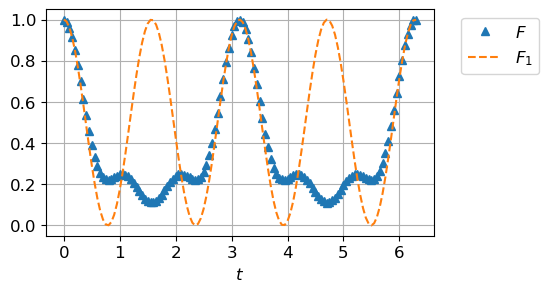

In [45]:
plt.figure(figsize = (5,3), dpi = 100)
plt.plot(t, F, '^', label = r'$F$'); plt.plot(t, F1, '--', label = r'$F_{1}$')
#plt.plot(t, F2, '-.', label = r'$F_{2}$'); plt.plot(t, F3, ':', label = r'$F_{3}$')
#plt.plot(t, F4, '.', label = r'$F_{4}$'); plt.plot(t, F5, '*', label = r'$F_{5}$')
plt.xlabel(r'$t$'); plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
plt.grid(); plt.show()

# esse cálculo "simbólico" demora muito. Melhor usar o numpy!

## Implementação usando numpy e scipy

In [16]:
# matrizes de Pauli
I = np.array([[1,0],[0,1]]); #print(I)
X = np.array([[0,1],[1,0]]); #print(X)
Y = np.array([[0,-1j],[1j,0]]);# print(Y)
Z = np.array([[1,0],[0,-1]]); #print(Z)

In [17]:
def Hxxx_num():
    H = np.kron(np.kron(X,X),I) + np.kron(I,np.kron(X,X))\
    + np.kron(np.kron(Y,Y),I) + np.kron(I,np.kron(Y,Y))\
    + np.kron(np.kron(Z,Z),I) + np.kron(I,np.kron(Z,Z))
    return H
H = Hxxx_num(); print(H.real)

[[ 2.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  2.  0.  0.  0.  0.  0.]
 [ 0.  2. -2.  0.  2.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  2.  0.  0.]
 [ 0.  0.  2.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  2.  0. -2.  2.  0.]
 [ 0.  0.  0.  0.  0.  2.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  2.]]


In [18]:
# para calcular a função de matriz (teve problemas de pequenas oscilações)
def proj_num(psi): 
    #return np.outer(psi, np.ndarray.conjugate(psi))
    d = len(psi); proj = np.zeros((d, d), dtype = complex)
    for j in range(0, d):
        for k in range(0, d):
            proj[j,k] = psi[j]*np.conj(psi[k])
    return proj
proj_num(np.array([[1],[1j]]))

array([[1.+0.j, 0.-1.j],
       [0.+1.j, 1.+0.j]])

In [19]:
import cmath
#from math import e
# para calcular a função de matriz (teve problemas de pequenas oscilações)
def mat_exp_num(A): 
    d = A.shape[0]; Aexp = np.zeros((d,d), dtype = complex); 
    eva, eve = np.linalg.eig(A);
    # eva, eve = scipy.linalg.eig(A)
    for j in range(0, d):
        Aexp += cmath.exp(eva[j])*proj_num(eve[:,j])
        #Aexp += e**(eva[j])*proj_num(eve[:,j])
    return Aexp
mat_exp_num(Y)

array([[1.54308063+0.j        , 0.        -1.17520119j],
       [0.        +1.17520119j, 1.54308063+0.j        ]])

In [20]:
def UHxxx_num(t):
    H = Hxxx_num()
    #return mat_exp_num(-1j*t*H)
    return scipy.linalg.expm(-1j*t*H) # resolveu o problema das pequenas flutuações
U = UHxxx_num(0*math.pi); U.real

array([[1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1.]])

In [21]:
def ip_num(a, b):
    d = a.shape[0]; ip = 0
    for j in range(0, d):
        ip += np.conj(a[j])*b[j]
    return ip
a = np.array([[1],[1j]]); b = np.array([[1],[1j]]); ip_num(a, b)

array([2.+0.j])

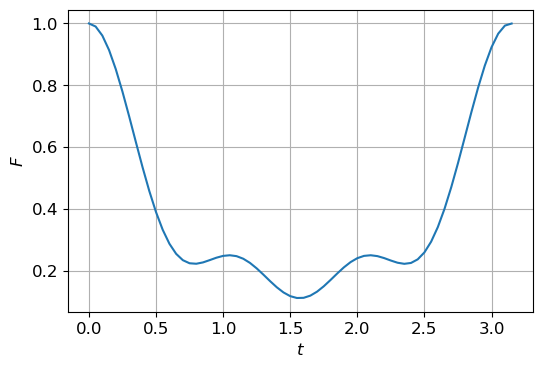

In [51]:
ket0 = np.array([[1],[0]]); ket1 = np.array([[0],[1]]); #ket0, ket1
dt = 0.05; t = np.arange(0, math.pi+dt, dt); d = len(t); F = np.zeros(d);  psit = np.zeros(d, dtype = complex)
psi0 = np.zeros(d, dtype = complex); psi0 = np.kron(ket1, np.kron(ket1, ket0)); #psi0
for j in range(0, d):
    U = UHxxx_num(t[j]); psit = np.dot(U, psi0)
    ip = ip_num(psi0, psit); F[j] = np.abs(ip)**2
plt.figure(figsize = (6,4), dpi = 100)
plt.plot(t, F); plt.xlabel(r'$t$'); plt.ylabel(r'$F$'); plt.grid(); plt.show()

In [23]:
H2 = np.kron(X, X) + np.kron(Y, Y) + np.kron(Z, Z)
def UHxxx12_num(t):
    H = np.kron(H2, I)
    return scipy.linalg.expm(-1j*t*H)
def UHxxx23_num(t):
    H = np.kron(I, H2)
    return scipy.linalg.expm(-1j*t*H)

In [24]:
dt = 0.05; t = np.arange(0, math.pi+dt, dt); d = len(t)
F1 = np.zeros(d); F2 = np.zeros(d); F3 = np.zeros(d); F4 = np.zeros(d); F5 = np.zeros(d)
F6 = np.zeros(d); F7 = np.zeros(d); F8 = np.zeros(d); F9 = np.zeros(d); F10 = np.zeros(d); F11 = np.zeros(d)
psi0 = np.zeros(d, dtype = complex); psi0 = np.kron(ket1, np.kron(ket1, ket0))
for j in range(0, d):
    U12 = UHxxx12_num(t[j]); U23 = UHxxx23_num(t[j])
    B = np.dot(U12, U23); U1 = np.linalg.matrix_power(B, 1); psit1 = np.dot(U1, psi0)
    ip = ip_num(psi0, psit1); F1[j] = np.abs(ip)**2
    U12 = UHxxx12_num(t[j]/2); U23 = UHxxx23_num(t[j]/2)
    B = np.dot(U12, U23); U2 = np.linalg.matrix_power(B, 2); psit2 = np.dot(U2, psi0)
    ip = ip_num(psi0, psit2); F2[j] = np.abs(ip)**2
    U12 = UHxxx12_num(t[j]/3); U23 = UHxxx23_num(t[j]/3)
    B = np.dot(U12, U23); U3 = np.linalg.matrix_power(B, 3); psit3 = np.dot(U3, psi0)
    ip = ip_num(psi0, psit3); F3[j] = np.abs(ip)**2
    U12 = UHxxx12_num(t[j]/4); U23 = UHxxx23_num(t[j]/4)
    B = np.dot(U12, U23); U4 = np.linalg.matrix_power(B, 4); psit4 = np.dot(U4, psi0)
    ip = ip_num(psi0, psit4); F4[j] = np.abs(ip)**2
    U12 = UHxxx12_num(t[j]/5); U23 = UHxxx23_num(t[j]/5)
    B = np.dot(U12, U23); U5 = np.linalg.matrix_power(B, 5); psit5 = np.dot(U5, psi0)
    ip = ip_num(psi0, psit5); F5[j] = np.abs(ip)**2
    U12 = UHxxx12_num(t[j]/6); U23 = UHxxx23_num(t[j]/6)
    B = np.dot(U12, U23); U6 = np.linalg.matrix_power(B, 6); psit6 = np.dot(U6, psi0)
    ip = ip_num(psi0, psit6); F6[j] = np.abs(ip)**2
    U12 = UHxxx12_num(t[j]/7); U23 = UHxxx23_num(t[j]/7)
    B = np.dot(U12, U23); U7 = np.linalg.matrix_power(B, 7); psit7 = np.dot(U7, psi0)
    ip = ip_num(psi0, psit7); F7[j] = np.abs(ip)**2
    U12 = UHxxx12_num(t[j]/8); U23 = UHxxx23_num(t[j]/8)
    B = np.dot(U12, U23); U8 = np.linalg.matrix_power(B, 8); psit8 = np.dot(U8, psi0)
    ip = ip_num(psi0, psit8); F8[j] = np.abs(ip)**2
    U12 = UHxxx12_num(t[j]/9); U23 = UHxxx23_num(t[j]/9)
    B = np.dot(U12, U23); U9 = np.linalg.matrix_power(B, 9); psit9 = np.dot(U9, psi0)
    ip = ip_num(psi0, psit9); F9[j] = np.abs(ip)**2
    U12 = UHxxx12_num(t[j]/10); U23 = UHxxx23_num(t[j]/10)
    B = np.dot(U12, U23); U10 = np.linalg.matrix_power(B, 10); psit10 = np.dot(U10, psi0)
    ip = ip_num(psi0, psit10); F10[j] = np.abs(ip)**2
    U12 = UHxxx12_num(t[j]/11); U23 = UHxxx23_num(t[j]/11)
    B = np.dot(U12, U23); U11 = np.linalg.matrix_power(B, 11); psit11 = np.dot(U11, psi0)
    ip = ip_num(psi0, psit11); F11[j] = np.abs(ip)**2
    if j == d-1:
        print('F5 = ', F5[j], 'F6 = ', F6[j])

F5 =  0.25775363032243465 F6 =  0.5765991261868881


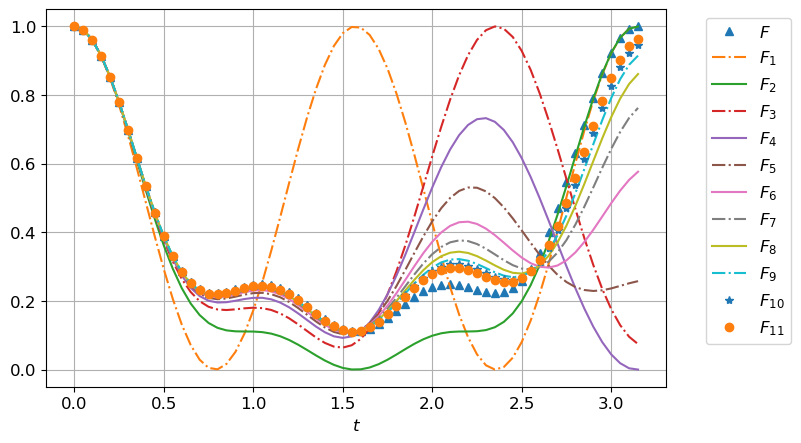

In [25]:
plt.figure(figsize = (8,5), dpi = 100)
plt.plot(t, F, '^', label = r'$F$'); plt.plot(t, F1, '-.', label = r'$F_{1}$')
plt.plot(t, F2, '', label = r'$F_{2}$'); plt.plot(t, F3, '-.', label = r'$F_{3}$')
plt.plot(t, F4, '', label = r'$F_{4}$'); plt.plot(t, F5, '-.', label = r'$F_{5}$')
plt.plot(t, F6, '', label = r'$F_{6}$'); plt.plot(t, F7, '-.', label = r'$F_{7}$')
plt.plot(t, F8, '', label = r'$F_{8}$'); plt.plot(t, F9, '-.', label = r'$F_{9}$')
plt.plot(t, F10, '*', label = r'$F_{10}$'); plt.plot(t, F11, 'o', label = r'$F_{11}$')
plt.xlabel(r'$t$'); plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
plt.grid(); plt.show()

Vemos que, de forma análoga à teoria de perturbação da MQ, na Trotterização não há obrigatoriamente uma melhora na aproximação conforme adicionamos um passo de Trotter. Vemos que para o tempo que nos interessa aqui, 
$$t=\pi,$$
temos, por exemplo, menor fidelidade para 4 passos de Trotter que para 3 passos: 
$$F_{4}(t=\pi)<F_{3}(t=\pi).$$
Na verdade, mesmo no caso exato, vemos que o número mínimo de passos de Trotter que precisamos usar para conseguir passar da fidelidade mínima exigida,
$$F_{\min} = 0.3,$$
deve ser 
$$n_{\min} = 6 \ \therefore\ F_{6}(t=\pi)\approx 0.5766,$$
já que
$$F_{5}(t=\pi)\approx 0.2577.$$
Notamos que depois de um certo número de passo, digamos $n=9$, a curva aproximada se aproxima muito lentamente da curva exata, indicando que para conseguir um resultado mais próximo do exato, teríamos que aumentar muito o número de passos de Trotter.

## Sobre a simulação e experimento
* $e^{-itZZ}$ <br>
Primeiramente, notemos que
$$ZZ|00\rangle = |00\rangle \text{, } ZZ|01\rangle = -|01\rangle \text{, } ZZ|10\rangle = -|10\rangle \text{, } ZZ|11\rangle = -|11\rangle.$$
Ou seja, a ação de $ZZ$ na base computacional depende da paridade do estado.
Notando que $Z=|0\rangle\langle 0|-|1\rangle\langle 1|$, vemos que
\begin{align}
ZZ & \equiv Z\otimes Z = (|0\rangle\langle 0|-|1\rangle\langle 1|)\otimes(|0\rangle\langle 0|-|1\rangle\langle 1|) \\
& = |00\rangle\langle 00| - |01\rangle\langle 01| - |10\rangle\langle 10| + |11\rangle\langle 11|.
\end{align}
Assim
\begin{align}
e^{-itZZ} & = \begin{bmatrix} e^{-it} & 0 & 0 & 0 \\ 0 & e^{it} & 0 & 0 \\ 0 & 0 & e^{it} & 0 \\ 0 & 0 & 0 & e^{-it}  \end{bmatrix} \\
& = e^{-it}(|00\rangle\langle 00|+|00\rangle\langle 00|) + e^{it}(|01\rangle\langle 01|+|10\rangle\langle 10|).
\end{align}
Ou seja, quando atua na base computacional, $e^{-itZZ}$ multiplica estados com paridade par por $ e^{-it}$ enquanto que estados com paridade ímpar são multiplicados por $e^{it}$.

Pode-se verificar também que
\begin{align}
C_{x}^{01}\big(I\otimes e^{-itZ}\big)C_{x}^{01} & = C_{x}^{01}\big(I\otimes e^{-itZ}\big)\big(|0\rangle\langle 0|\otimes I +|1\rangle\langle 1|\otimes X \big) \\
& = \big(|0\rangle\langle 0|\otimes I +|1\rangle\langle 1|\otimes X \big)\big(|0\rangle\langle 0|\otimes e^{-itZ} +|1\rangle\langle 1|\otimes e^{-itZ}X \big) \\
& = |0\rangle\langle 0|\otimes e^{-itZ} +|1\rangle\langle 1|\otimes Xe^{-itZ}X \\
& = |0\rangle\langle 0|\otimes \big(e^{-it}|0\rangle\langle 0|+e^{it}|1\rangle\langle 1|\big) +|1\rangle\langle 1|\otimes X \big(e^{-it}|0\rangle\langle 0|+e^{it}|1\rangle\langle 1|\big)X \\
& = |0\rangle\langle 0|\otimes \big(e^{-it}|0\rangle\langle 0|+e^{it}|1\rangle\langle 1|\big) +|1\rangle\langle 1|\otimes \big(e^{-it}|1\rangle\langle 1|+e^{it}|0\rangle\langle 0|\big) \\
& = e^{-it}|00\rangle\langle 00| + e^{it}|01\rangle\langle 01| + e^{-it}|11\rangle\langle 11| + e^{it}|10\rangle\langle 10| \\
& = e^{-itZZ}.
\end{align}

A porta lógica denominada rotação em torno de z do qiskit é
$$RZ(\lambda) = e^{-i\lambda Z/2}.$$
Portanto
$$e^{-itZ} = RZ(2t)$$
e
$$e^{-itZZ} = C_{x}^{01}\big(I\otimes RZ(2t)\big)C_{x}^{01}.$$

In [46]:
def qc_ezz(t):
    qc = QuantumCircuit(2, name = 'e^(-itZZ)')
    qc.cx(0, 1); qc.rz(2*t, 1); qc.cx(0, 1) 
    return qc
qc_ezz_ = qc_ezz(math.pi); qc_ezz_.draw()

q_0: ──■──────────────■──
     ┌─┴─┐┌────────┐┌─┴─┐
q_1: ┤ X ├┤ Rz(2π) ├┤ X ├
     └───┘└────────┘└───┘

* $e^{-itXX}$ <br>
Começamos notando que $X=|+\rangle\langle +|-|-\rangle\langle -|$, com $|\pm\rangle = (|0\rangle\pm|1\rangle)/\sqrt{2}$. Assim, temos que
$$XX = X\otimes X = (|++\rangle\langle ++|+|--\rangle\langle --|)-(|+-\rangle\langle +-|+|-+\rangle\langle -+|).$$
Assim
\begin{align}
e^{-itXX} & = e^{-it}(|++\rangle\langle ++|+|--\rangle\langle --|)+e^{it}(|+-\rangle\langle +-|+|-+\rangle\langle -+|) \\
& = HH\Big(e^{-it}(|00\rangle\langle 00|+|11\rangle\langle 11|)+e^{it}(|01\rangle\langle 01|+|10\rangle\langle 10|)\Big)HH \\
& = HHe^{-itZZ}HH \\
& = HHC_{x}^{01}\big(I\otimes e^{-itZ}\big)C_{x}^{01}HH
\end{align}

In [47]:
def qc_exx(t):
    qc = QuantumCircuit(2, name = 'e^(-itXX)')
    qc.h([0,1]); qc.cx(0, 1); qc.rz(2*t, 1); qc.cx(0, 1); qc.h([0,1])
    return qc
qc_exx_ = qc_exx(math.pi); qc_exx_.draw()

┌───┐                    ┌───┐
q_0: ┤ H ├──■──────────────■──┤ H ├
     ├───┤┌─┴─┐┌────────┐┌─┴─┐├───┤
q_1: ┤ H ├┤ X ├┤ Rz(2π) ├┤ X ├┤ H ├
     └───┘└───┘└────────┘└───┘└───┘

* $e^{-itYY}$ <br>
Começamos notando que $Y=|\oplus\rangle\langle \oplus|-|\ominus\rangle\langle \ominus|$, com $|\oplus\rangle = (|0\rangle+i|1\rangle)/\sqrt{2}$ e $|\ominus\rangle = (|0\rangle-i|1\rangle)/\sqrt{2}$. Assim, temos que
$$YY = (|\oplus\oplus\rangle\langle \oplus\oplus|+|\ominus\ominus\rangle\langle \ominus\ominus|)-(|\oplus\ominus\rangle\langle \oplus\ominus|+|\ominus\oplus\rangle\langle \ominus\oplus|).$$
Assim
\begin{align}
e^{-itYY} & = e^{-it}(|\oplus\oplus\rangle\langle \oplus\oplus|+|\ominus\ominus\rangle\langle \ominus\ominus|) + e^{it}(|\oplus\ominus\rangle\langle \oplus\ominus|+|\ominus\oplus\rangle\langle \ominus\oplus|) \\
& = (SS)(HH)\Big(e^{-it}(|00\rangle\langle 00|+|11\rangle\langle 11|)+e^{it}(|01\rangle\langle 01|+|10\rangle\langle 10|)\Big)(HH)(S^{\dagger}S^{\dagger}) \\
& = (SS)(HH)e^{-itZZ}(HH)(S^{\dagger}S^{\dagger}) \\
& = (SS)(HH)C_{x}^{01}\big(I\otimes e^{-itZ}\big)C_{x}^{01}(HH)(S^{\dagger}S^{\dagger})
\end{align}

In [48]:
def qc_eyy(t):
    qc = QuantumCircuit(2, name = 'e^(-itYY)')
    qc.s([0,1]); qc.h([0,1]); qc.cx(0, 1); qc.rz(2*t, 1); qc.cx(0, 1); qc.h([0,1]); qc.sdg([0,1])
    return qc
qc_eyy_ = qc_eyy(math.pi); qc_eyy_.draw()

┌───┐┌───┐                    ┌───┐┌─────┐
q_0: ┤ S ├┤ H ├──■──────────────■──┤ H ├┤ Sdg ├
     ├───┤├───┤┌─┴─┐┌────────┐┌─┴─┐├───┤├─────┤
q_1: ┤ S ├┤ H ├┤ X ├┤ Rz(2π) ├┤ X ├┤ H ├┤ Sdg ├
     └───┘└───┘└───┘└────────┘└───┘└───┘└─────┘

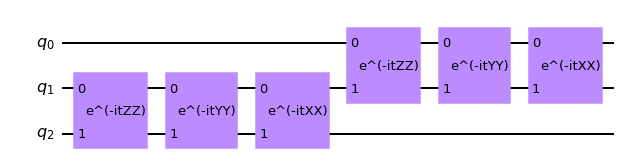

In [49]:
def Bj(t):
    qc = QuantumCircuit(3, name = 'B_j')
    qc_ezz_ = qc_ezz(t); qc_eyy_ = qc_eyy(t); qc_exx_ = qc_exx(t)
    qc.append(qc_ezz_, [1, 2]); qc.append(qc_eyy_, [1, 2]); qc.append(qc_exx_, [1, 2])
    qc.append(qc_ezz_, [0, 1]); qc.append(qc_eyy_, [0, 1]); qc.append(qc_exx_, [0, 1])
    return qc
Bj_ = Bj(math.pi/2); Bj_.draw(output='mpl')

In [52]:
def qc_psi0():
    qc = QuantumCircuit(3, name = 'psi0')
    qc.x([0,1])
    return qc
qc_psi0_ = qc_psi0(); qc_psi0_.draw()

┌───┐
q_0: ┤ X ├
     ├───┤
q_1: ┤ X ├
     └───┘
q_2: ─────

Fidelidade entre um estado puro e um misto
\begin{align}
F(\rho,\psi) = \langle\psi|\rho|\psi\rangle = \sum_{j,k=0}^{d-1}\psi_{j}^{*}\rho_{j,k}\psi_{k}.
\end{align}

In [69]:
def F_psi_rho_num(psi, rho):
    d = rho.shape[0]; F = 0
    for j in range(0, d):
        for k in range(0, d):
            F += np.conj(psi[j])*rho[j,k]*psi[k]
    return F.real
psi = [1/math.sqrt(2),1j/math.sqrt(2)]; rho = 0.5*np.array([[1,-1j],[1j,1]])
F = F_psi_rho_num(psi, rho); print(F) # ok!

0.9999999999999998


In [82]:
nshots = 8192
qiskit.IBMQ.load_account()
#provider = qiskit.IBMQ.get_provider(hub='ibm-q', group='open', project='main')
provider = qiskit.IBMQ.get_provider(hub = 'ibm-q-research-2', group = 'federal-uni-sant-1', project = 'main')
simulator = Aer.get_backend('qasm_simulator')
device = provider.get_backend('ibmq_jakarta')
from qiskit.tools.monitor import job_monitor
from qiskit.ignis.verification.tomography import state_tomography_circuits, StateTomographyFitter

ibmqfactory.load_account:WARNING:2022-01-07 16:27:48,581: Credentials are already in use. The existing account in the session will be replaced.


In [83]:
psi0 = [0, 0, 0, 1, 0, 0, 0, 0]; 
# troca a ordem, |110> -> |011>, por causa da ordem dos qubits que vem da tomografia

In [ ]:
dt = 0.1; t = np.arange(0, math.pi+dt, dt); d = len(t)
Fs = np.zeros(d); Fe = np.zeros(d)
for j in range(0, d):
    qc = QuantumCircuit(3)
    qc_psi0_ = qc_psi0(); qc.append(qc_psi0_, [0, 1, 2])
    Bj_ = Bj(t[j]/2); qc.append(Bj_, [0, 1, 2]); qc.append(Bj_, [0, 1, 2])
    qstc = state_tomography_circuits(qc, [0, 1, 2])
    # simulation
    job = qiskit.execute(qstc, backend = simulator, shots = nshots)
    qstf = StateTomographyFitter(job.result(), qstc)
    rho = qstf.fit(method = 'lstsq')
    Fs[j] = F_psi_rho_num(psi0, rho)
    # experiment
    jobE = qiskit.execute(qstc, backend = device, shots = nshots)
    print(jobE.job_id()); job_monitor(jobE)
    qstfE = StateTomographyFitter(jobE.result(), qstc)
    rhoE = qstfE.fit(method = 'lstsq')
    Fe[j] = F_psi_rho_num(psi0, rhoE)
qc.draw()

61d89442d1eb0742d64913ca
Job Status: job is queued (1)     

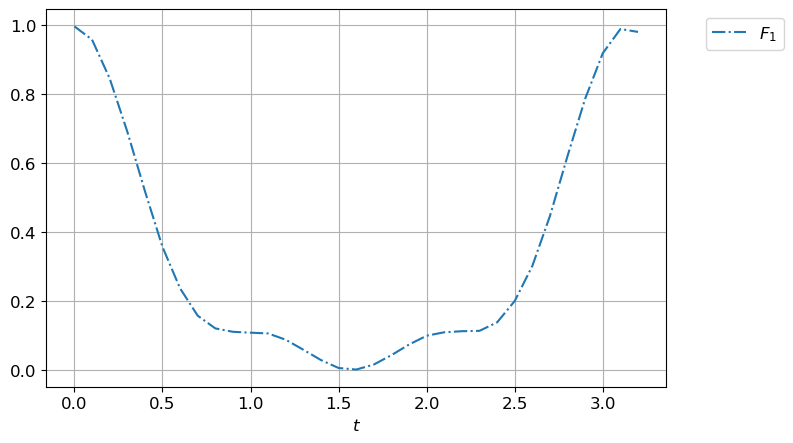

In [75]:
plt.figure(figsize = (8,5), dpi = 100)
plt.plot(t, Fs, '-.', label = r'$F_{s}$'); plt.plot(t, Fe, '-.', label = r'$F_{e}$')
plt.xlabel(r'$t$'); plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
plt.grid(); plt.show()
# a simulação funcionou para j = 1 (demora um pouco para executar)
# a simulação funcionou tb para j = 2

## Resultados que interessam para o desafio
Fazer os cálculos somente para $t=\pi$. Fazer os cálculos exato, simulação e experimento, mudando o número de passos de Trotter.

## Sobre o chip jakarta
Analisar a estrutura do chip, para verificação de tempos de coerência e relaxação de cada qubit, erros de CNOTs e conectividade.

## Usando as simetrias do hamiltoniano
Usar efeito Zenão para cancelar erros através de repeditas aplicações de operações de simetria (rotações locais).

## Usando pulsos
Ver como pulsos são usados, o que se poder fazer com eles e como usar redes neurais artificiais pra a escolha das sequências de pulsos a serem aplicados de forma a diminuir os erros de implementação.

Fazer tomografia de processos para identificar erros sistemáticos de portas e do circuito como um todo e utilizar pulsos adicionais para corrigir esses erros.

Usar sequência de pulsos aleatórios que se cancelam no final da evolução.

### Referências
* Yuan Su, Trotterization and Trotter error (https://youtu.be/KPofFJc57gU).
* IBM QUANTUM AWARDS: OPEN SCIENCE PRIZE 2021 (https://ibmquantumawards.bemyapp.com/#/event?email_confirmed=true).